<div align="center" style="line-height: 1.7;">
    <h2 style="font-weight: 600;"><strong>Robustness & Generalization</strong></h2>
</div> 

&nbsp;

Reinforcement learning algorithms are often evaluated in clean, stationary environments. But real-world systems, robots, autonomous vehicles, adaptive controllers, must operate under noise, randomness, environment changes, and unpredictable initial conditions.
A policy that works well only under ideal conditions is not truly successful: it must remain effective when the environment shifts, randomness increases, or different seeds produce different experience trajectories.

This notebook introduces two essential robustness evaluations:

---

### Zero-Shot Robustness (Environment Shift Robustness)

Here, we train Q-Learning, SARSA, and Dyna-Q in a baseline GridWorld and then evaluate them without retraining in a modified “windy” environment with higher stochasticity.
This tests whether each algorithm learns a policy that:

* generalizes beyond the exact training dynamics,

* remains reliable under changes in transition probabilities, and

* avoids brittle behaviors that depend on low-noise assumptions.

This type of robustness is especially important in model-based algorithms like Dyna-Q, where the learned model can be biased or incorrect when conditions shift.
A model that matched the training environment may fail to represent the new dynamics, revealing whether the policy depends too strongly on the learned transition model.

Zero-shot robustness asks:

**How well do policies trained under one environment perform when the environment changes?**

---

### Seed Stability (Stochastic Training Robustness)

Even if the environment does not change, different random seeds create variation in:

* starting RNG state

* stochastic action outcomes (wind)

* exploration randomness

* sampling order in Dyna-Q planning

* path taken during training

Algorithms that are sensitive to seed variation produce unstable returns, inconsistent policies, and unpredictable final performance.

Seed stability evaluates:

**Does the algorithm learn consistently across multiple random seeds, or is performance unstable and unpredictable?**

This is particularly relevant for Dyna-Q, because:

* The internal model is built online; the first time steps determine early model structure.

* Early random transitions can be replayed many times during planning → amplifying seed effects.

* A biased early model may propagate through many simulated updates (especially with large K).

Thus, Dyna-Q can be more sensitive to seed differences than pure Q-Learning or SARSA — testing robustness reveals whether planning amplifies noise or stabilizes learning.

---

### Why Robustness Matters for Dyna-Q Specifically

Dyna-Q’s strength comes from mixing real experience with model-based planning.

But that introduces two potential weaknesses:

1. Model sensitivity

If the learned model is inaccurate — due to noise, exploration randomness, or limited coverage — planning can reinforce incorrect transitions many times.

2. Amplification of early randomness

Since Dyna-Q replays early experiences repeatedly, the random seed at the start of training can have outsized influence on the final solution.

3. Environment shift mismatch

Policies optimized using a learned model may be less robust when the true environment changes, because the internal model is tied to old dynamics.

By performing robustness evaluations, both environment-shift and seed-stability, we reveal:

* whether planning helps or hurts under variation,

* whether Dyna-Q is stable across runs,

* how robust each algorithm is compared to pure model-free baselines.

---


## 1) Import & Environment Setup
This section imports all the necessary code and libraries. (There will be an `environment setup` in every notebook, it is necessary for the correct functioning of the algorithms and future analysis)

In [1]:
# ---  Notebook Setup ----------------------------------------------------
import sys, os
from pathlib import Path
from IPython import get_ipython
import importlib
import matplotlib.pyplot as plt
from dataclasses import dataclass, replace
from typing import Optional, List, Dict, Tuple
import numpy as np

GREEN = "\033[92m"; RED = "\033[91m"; RESET = "\033[0m"

try:
    root = Path.cwd()
    src_path = (root / "../src").resolve()

    # 1) Make sure local ../src wins over site-packages
    if str(src_path) not in sys.path:
        sys.path.insert(0, str(src_path))

    ip = get_ipython()
    if ip:
        ip.run_line_magic("load_ext", "autoreload")
        ip.run_line_magic("autoreload", "2")

    # 2) Import and *verify* we’re loading the right files
    import rl_capstone
    import rl_capstone.rl_algorithms as rla
    print("rl_capstone from:", getattr(rl_capstone, "__file__", "?"))
    print("rl_algorithms from:", getattr(rla, "__file__", "?"))

    # 3) Force a reload in case kernel already loaded the old one
    importlib.reload(rla)

    # 4) Now import the names (after reload)
    from rl_capstone import GridWorld, WorldSettings
    
    from rl_capstone.rl_algorithms import (
        TrainConfig,
        q_learning_train_with_logs,
        sarsa_train_with_logs,
        dyna_q_train_with_logs,
    )
    from rl_capstone.utils import (
        evaluate_policy,
        greedy_policy_from_0,
        rolling,
    )


    print(f"{GREEN}Environment setup complete!{RESET}")

except Exception as e:
    print(f"{RED}Setup failed:{RESET}", e)


rl_capstone from: /Users/houndsito/Documents/Development/github/fcampoverdeg/reinforcement_learning/src/rl_capstone/__init__.py
rl_algorithms from: /Users/houndsito/Documents/Development/github/fcampoverdeg/reinforcement_learning/src/rl_capstone/rl_algorithms.py
Environment setup complete!


## 2) Build & Preview the environment
This section is for visualization purposes, the user can see the world where the agent will be performing its tasks, this can be changed by the user by adding walls, pits, changing the position of the starting point and the goal, as well as the size of the Grid World.

(For more information on how to use the `GridWorld` class please check: [GridWorld](../src/rl_capstone/rl_algorithms.py))


States=121, Actions=4, Grid=11x11



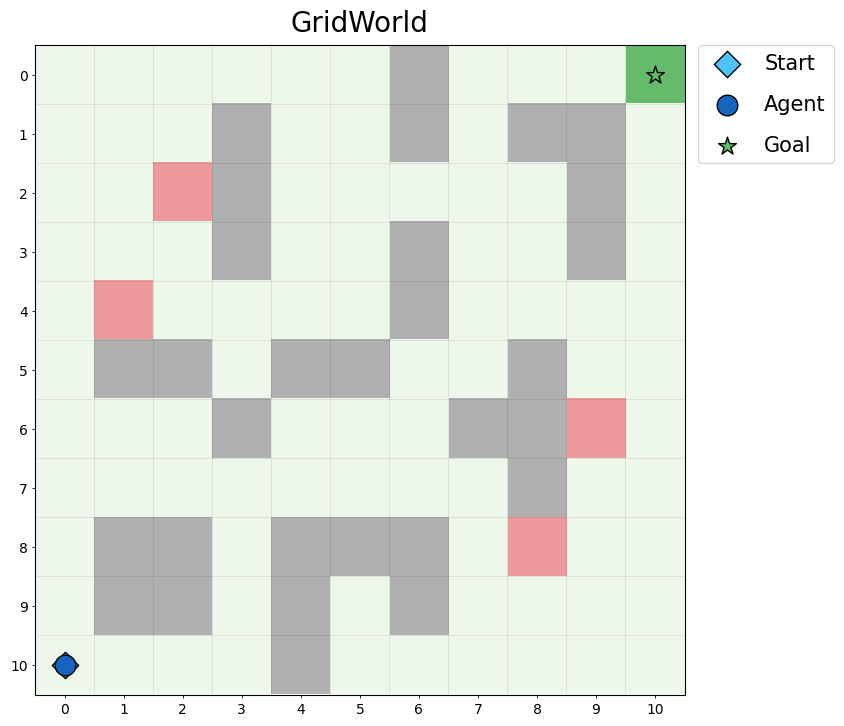

In [2]:
# Instantiate environment with your WorldSettings
settings = WorldSettings()      # tweak if you want a different map
env = GridWorld(settings)
env.seed(7)

print(f"\nStates={env.num_states}, Actions={env.num_actions}, Grid={env.rows}x{env.cols}\n")

env.render(title="GridWorld")

## 3) Log Config

This section controls how often the log training progress is and how many episodes are run to measure greedy performance at each snapshot.

Users can change the limit of snapshots, episodes and seed, which will affect factors like: `Wind randomness`, `Transition noise`, `Length and returns of greedy evaluation episodes`.

In [3]:
# Tweak depending on user preferences
@dataclass
class LogConfig:
    snapshot_every: int = 40    # take a snapshot every N episodes
    eval_episodes: int = 5      # greedy evals per snapshot
    seed: Optional[int] = 7

print(f"{GREEN}Log Config Setup!{RESET}")

Log Config Setup!


## 4) Train Configuration + Log Config
In this section the user can set up the configurations needed for training the agent.

In [4]:
cfg = TrainConfig(
    episodes=750,
    max_steps=1000,
    alpha=0.10,
    gamma=0.99,
    eps_start=1.0,
    eps_end=0.05,
    eps_decay_steps=10_000,
    seed=42,
    q_init=0.0
)

logcfg = LogConfig(snapshot_every=40, eval_episodes=5, seed=7)

## 5) Import Q-Tables from `Comparison notebook`

For this section, the user can import that `Q-Tables` that were obtained from [Dyna-Q Planning Steps Sweep](05_k_sweep.ipynb)

In [5]:
paths = {
    "Q-Learning": "../data/q_tables/Q_q.npy",
    "SARSA": "../data/q_tables/Q_sarsa.npy",
    "Dyna-Q": "../data/q_tables/Q_dyna.npy"
}

results = {}
load_status = {}

for name, path in paths.items():
    try:
        Q = np.load(path)
        results[name] = {"Q": Q, "logs": None}
        load_status[name] = "OK"
    except Exception as e:
        load_status[name] = f"FAILED ({e.__class__.__name__})"

# --- Print summary table ---
print("\nLoad Summary:")
for k, v in load_status.items():
    if "OK" in v:
        print(f"{GREEN}{k:<12} : {v}{RESET}")
    else:
        print(f"{RED}{k:<12} : {v}{RESET}")

print("\nModels available:", list(results.keys()))



Load Summary:
Q-Learning   : OK
SARSA        : OK
Dyna-Q       : OK

Models available: ['Q-Learning', 'SARSA', 'Dyna-Q']


## 6) Helper Functions
To be able to test the robustness of Dyna-Q, the user will make use of the following helper functions.

In [11]:
ALGOS = {
    "Q-Learning": q_learning_train_with_logs,
    "SARSA":      sarsa_train_with_logs,
    "Dyna-Q":     dyna_q_train_with_logs,
}


def run_all_algorithms(env, cfg: TrainConfig, logcfg: LogConfig):
    """
    Train all RL algorithms defined in ALGOS on a given environment.

    Parameters
    ----------
    env : GridWorld
        Environment used for training (baseline or windy).
    cfg : TrainConfig
        Hyperparameter configuration for training (episodes, steps, alpha, etc.).
    logcfg : LogConfig
        Logging configuration controlling snapshot frequency and evaluation runs.

    Returns
    -------
    dict
        Mapping:
        {
            "AlgorithmName": {
                "Q":    np.ndarray (Q-table),
                "logs": dict (returns, steps, snapshots)
            },
            ...
        }
    """
    results = {}
    for name, train_fn in ALGOS.items():
        print(f"\n=== Training {name} ===")
        Q, logs = train_fn(env, cfg, logcfg)
        results[name] = {"Q": Q, "logs": logs}
    return results


def save_plot(path, filename):
    """
    Save the current matplotlib figure to the given directory+filename.

    Example:
        save_plot("../reports/figs/robustness/windy", "windy_return.png")
    """
    os.makedirs(path, exist_ok=True)
    full_path = os.path.join(path, filename)
    plt.savefig(full_path, dpi=300, bbox_inches="tight")
    print(f"Saved: {full_path}")



def plot_learning_curves(results_dict, title_prefix="", save_dir=None, prefix=""):
    """
    Plot smoothed learning curves (returns and episode lengths) for multiple algorithms.
    If save_dir is provided, save both figures in that directory.
    
    Parameters
    ----------
    results_dict : dict
        The output of `run_all_algorithms`, containing Q-tables and logs.
    title_prefix : str, optional
        A prefix for figure titles (e.g., "Baseline Env", "Windy Env").
    save_dir: str, optional
        Specifies the path where the graphs will be stored (used for report)

    Notes
    -----
    Uses a rolling average (window=25) for readability.  
    Produces two separate figures:
      1. Return per episode (smoothed)
      2. Episode length (smoothed)
    """
    # --- Return curve ---
    plt.figure(figsize=(9,4))
    for name, res in results_dict.items():
        returns = res["logs"]["returns"]
        smooth = rolling(returns, 25)
        plt.plot(smooth, label=name, linewidth=2)

    plt.title(f"{title_prefix} — Return per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Return (rolling avg)")
    plt.grid(True)
    plt.legend()

    if save_dir is not None:
        save_plot(save_dir, f"{prefix}_returns.png")
    plt.show()

    # --- Episode length curve ---
    plt.figure(figsize=(9,4))
    for name, res in results_dict.items():
        steps = res["logs"]["steps"]
        smooth = rolling(steps, 25)
        plt.plot(smooth, label=name, linewidth=2)

    plt.title(f"{title_prefix} — Episode Length")
    plt.xlabel("Episode")
    plt.ylabel("Steps (rolling avg)")
    plt.grid(True)
    plt.legend()

    if save_dir is not None:
        save_plot(save_dir, f"{prefix}_steps.png")
    plt.show()



def greedy_eval_on_env(env, results_dict, cfg, desc=""):
    """
    Evaluate each algorithm's learned Q-table greedily (no exploration).

    Parameters
    ----------
    env : GridWorld
        Environment on which greedy evaluation is performed.
    results_dict : dict
        Output structure from `run_all_algorithms`.
    cfg : TrainConfig
        Used for retrieving max_steps during evaluation.
    desc : str, optional
        Printed label describing the evaluation environment 
        (e.g., "Baseline Env", "Windy Env").

    Prints
    ------
    For each algorithm:
        Return=<mean over 30 episodes>
        Steps=<mean episode length>
    """
    print(f"\nGreedy evaluation on: {desc}")
    print("-" * 60)
    for name, res in results_dict.items():
        Q = res["Q"]
        pi = greedy_policy_from_0(Q)
        mean_return, mean_length = evaluate_policy(
            env, pi, episodes=30, max_steps=cfg.max_steps, seed=123
        )
        print(f"{name:10s} | Return={mean_return:.3f} | Steps={mean_length:.1f}")


def seed_stability_experiment(env, base_cfg: TrainConfig, logcfg: LogConfig,
                              seeds: List[int], last_n: int = 50):
    """
    Run seed stability robustness experiment for all algorithms.

    For each seed:
      - Clone the base configuration with cfg.seed = that seed
      - Train each algorithm once
      - Record mean return and episode length over the last `last_n` episodes

    Parameters
    ----------
    env : GridWorld
        Environment used for all seeds (baseline or windy).
    base_cfg : TrainConfig
        Base hyperparameters before inserting the specific seed.
    logcfg : LogConfig
        Logging configuration.
    seeds : list of int
        List of seeds to test (e.g., [0, 1, 2, 3, 4]).
    last_n : int
        Number of tail episodes used to compute final performance statistics.

    Returns
    -------
    dict
        A structure of the form:

        {
            "Q-Learning": {
                "final_returns": [ret_seed0, ret_seed1, ...],
                "final_steps":   [len_seed0, len_seed1, ...]
            },
            "SARSA": { ... },
            "Dyna-Q": { ... }
        }

    Notes
    -----
    This experiment measures:
      - Training stability under different RNG seeds
      - Sensitivity to early randomness in transitions & planning
    """
    stats = {
        name: {"final_returns": [], "final_steps": []}
        for name in ALGOS.keys()
    }

    for seed in seeds:
        print(f"\n### Seed = {seed} ###")
        cfg_seed = replace(base_cfg, seed=seed)
        for name, train_fn in ALGOS.items():
            print(f"  Training {name}...")
            Q, logs = train_fn(env, cfg_seed, logcfg)
            returns = logs["returns"]
            steps   = logs["steps"]

            final_ret   = float(np.mean(returns[-last_n:]))
            final_steps = float(np.mean(steps[-last_n:]))

            stats[name]["final_returns"].append(final_ret)
            stats[name]["final_steps"].append(final_steps)

    return stats


## 7) Robustness to Transition Noise (winds)
The section provides a complete robustness study:

* **Zero-shot test:** How much performance drops when applying the original policies to a windier world.

* **Retraining test:** How quickly each algorithm adapts to noisy transitions when trained in that environment.

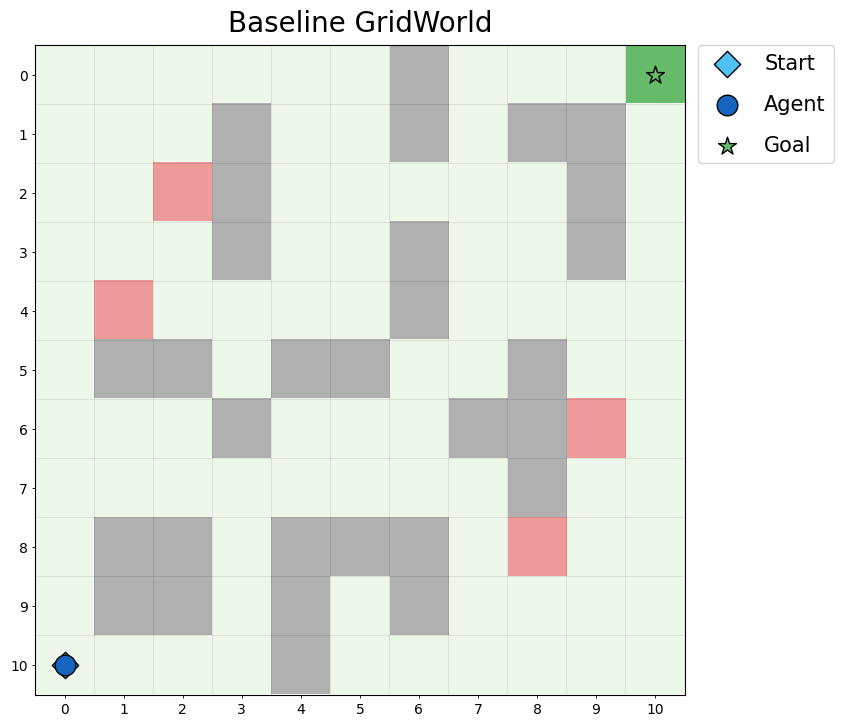

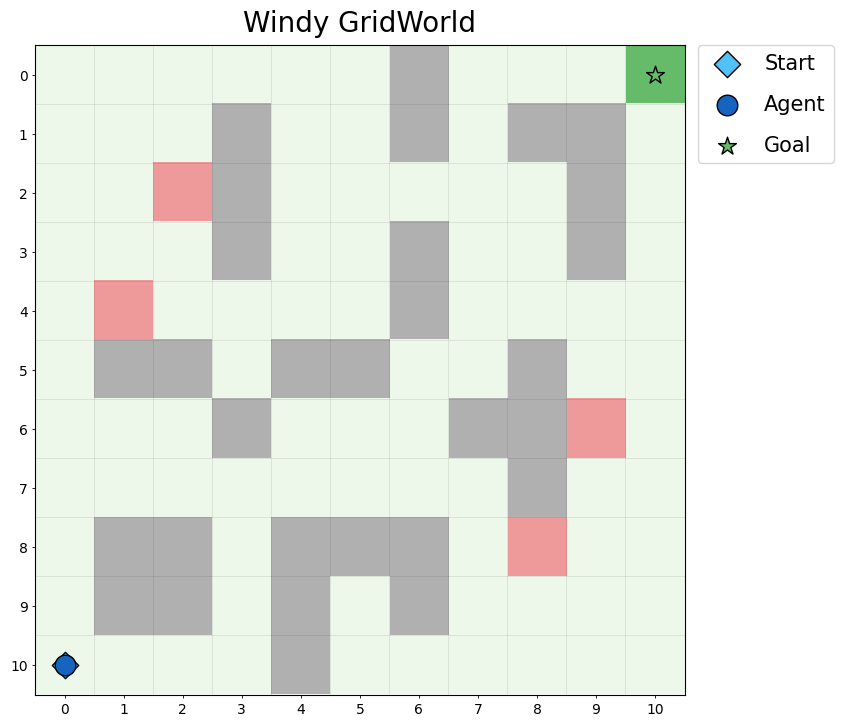


Greedy evaluation on: Windy env (policies trained on baseline env)
------------------------------------------------------------
Q-Learning | Return=0.314 | Steps=66.3
SARSA      | Return=0.698 | Steps=31.2
Dyna-Q     | Return=0.701 | Steps=30.9

Training all algorithms on windy env...

=== Training Q-Learning ===

=== Training SARSA ===

=== Training Dyna-Q ===
Saved: ../reports/figs/robustness/windy/windy_returns.png


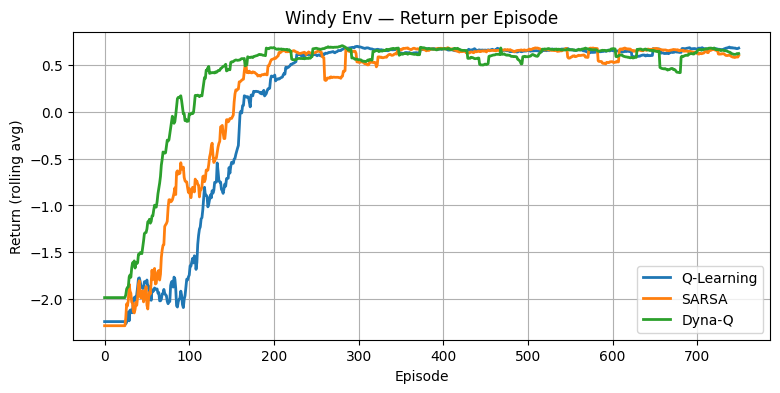

Saved: ../reports/figs/robustness/windy/windy_steps.png


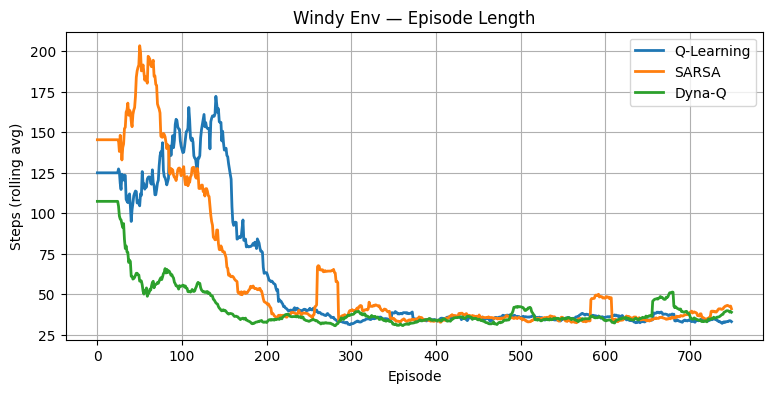


Greedy evaluation on: Windy env (policies trained on windy env)
------------------------------------------------------------
Q-Learning | Return=0.683 | Steps=32.7
SARSA      | Return=0.675 | Steps=33.5
Dyna-Q     | Return=0.656 | Steps=35.4


In [12]:
# 1) Windy environment (higher transition noise)
windy_settings = replace(settings, wind_chance=0.30)  # Change wind probability
env_windy = GridWorld(windy_settings)
env_windy.seed(7)

env.render(title="Baseline GridWorld")
env_windy.render(title="Windy GridWorld")

# 2) ZERO-SHOT ROBUSTNESS:
#    Evaluate PRETRAINED Q-tables (loaded from .npy) on the new windy env.
#    Here, `results` comes from:
#      Q_q = np.load("Q_q.npy"), etc.
#      results = {"Q-Learning": {"Q": Q_q, ...}, ...}
greedy_eval_on_env(
    env_windy,
    results,
    cfg,
    desc="Windy env (policies trained on baseline env)"
)

# 3) TRAINING FROM SCRATCH ON WINDY ENV:
#    This does *not* use the loaded Q-tables; it runs new training runs
#    of Q-learning, SARSA, and Dyna-Q directly on env_windy.
cfg_windy = replace(cfg, seed=42)

print("\nTraining all algorithms on windy env...")
windy_results = run_all_algorithms(env_windy, cfg_windy, logcfg)

# Here is where you save your ROBUSTNESS figures for LaTeX
plot_learning_curves(
    windy_results,
    title_prefix="Windy Env",
    save_dir="../reports/figs/robustness/windy",
    prefix="windy"
)

# 4) Evaluate the policies that were trained *on* the windy env
greedy_eval_on_env(
    env_windy,
    windy_results,
    cfg_windy,
    desc="Windy env (policies trained on windy env)"
)


### Path Visualization Windy Environment

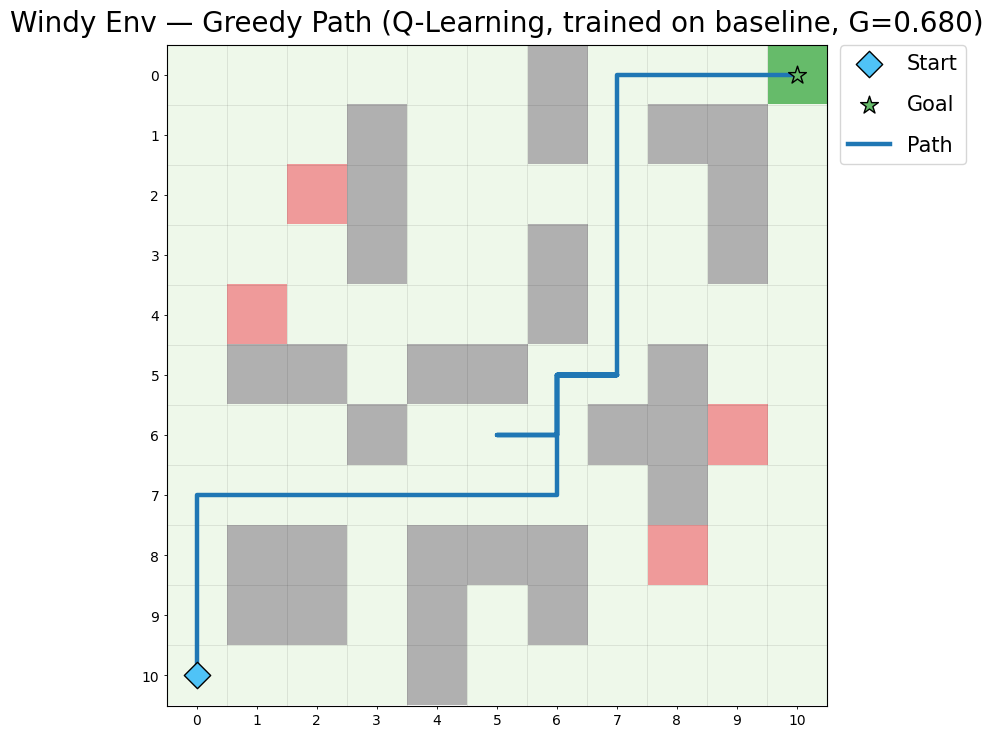

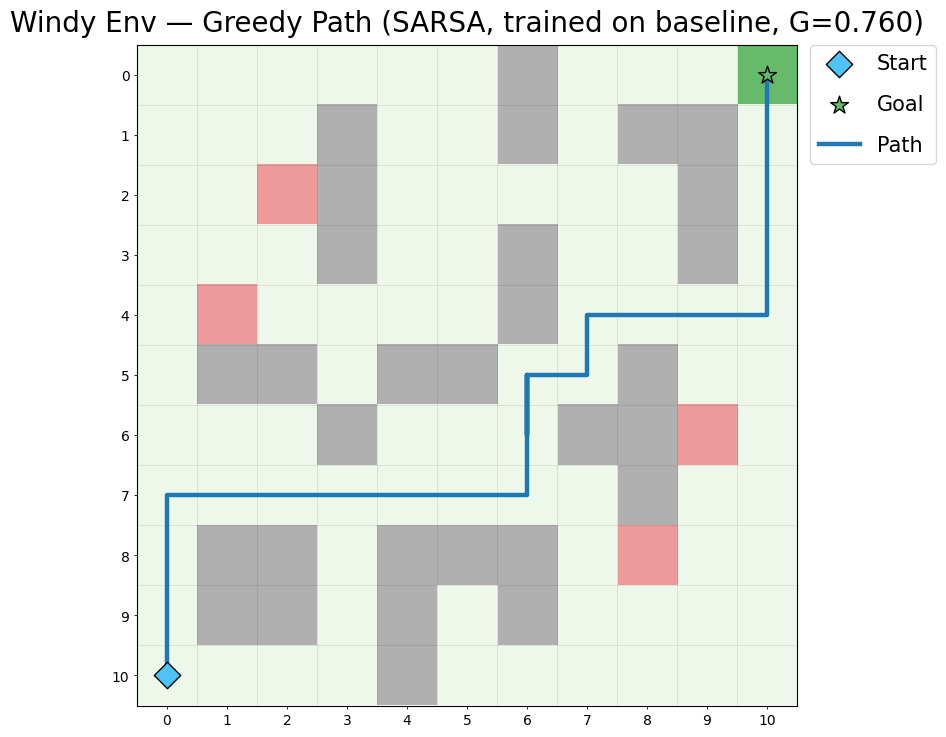

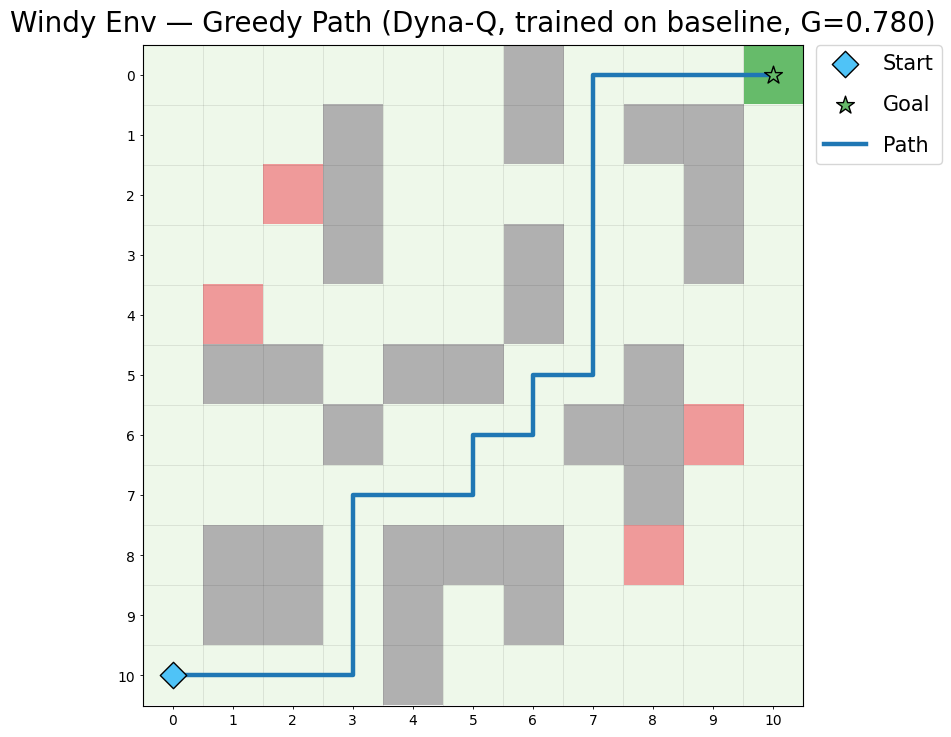

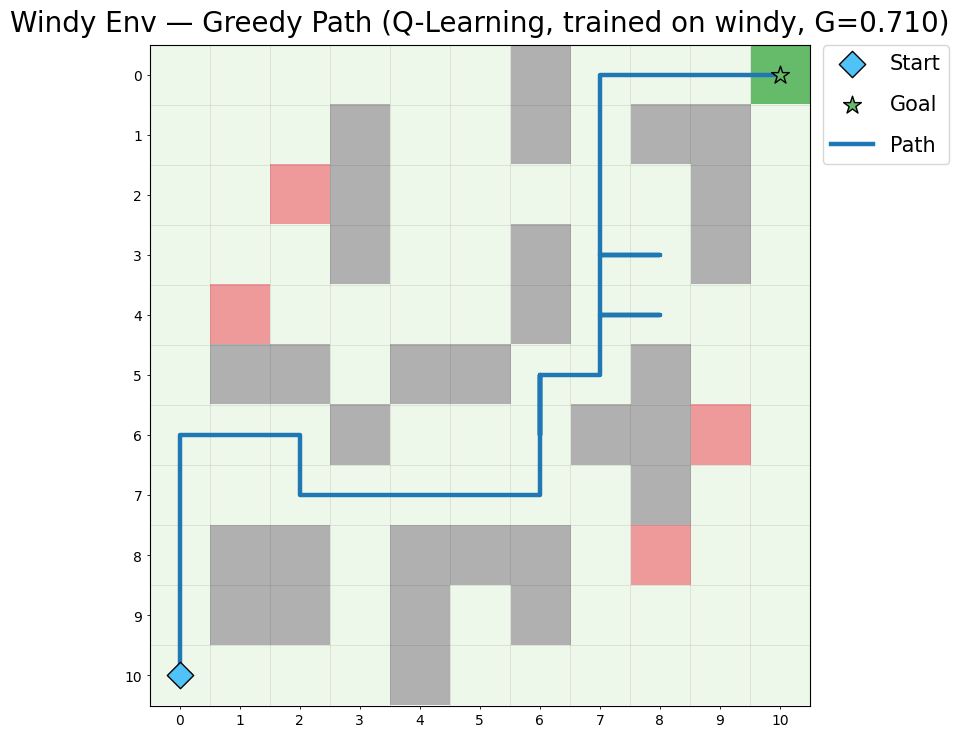

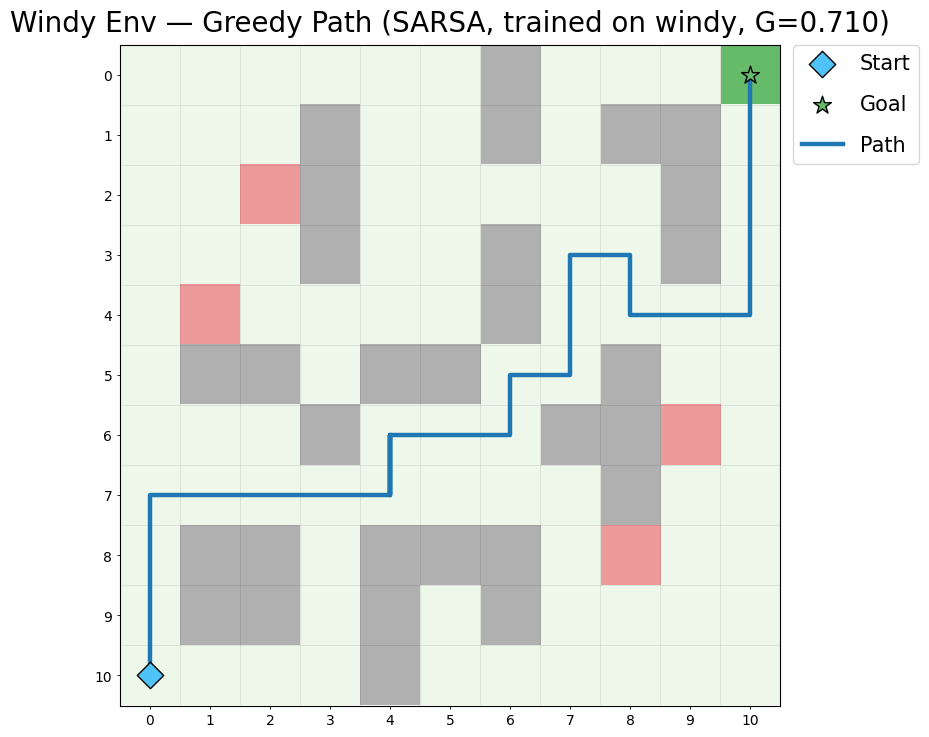

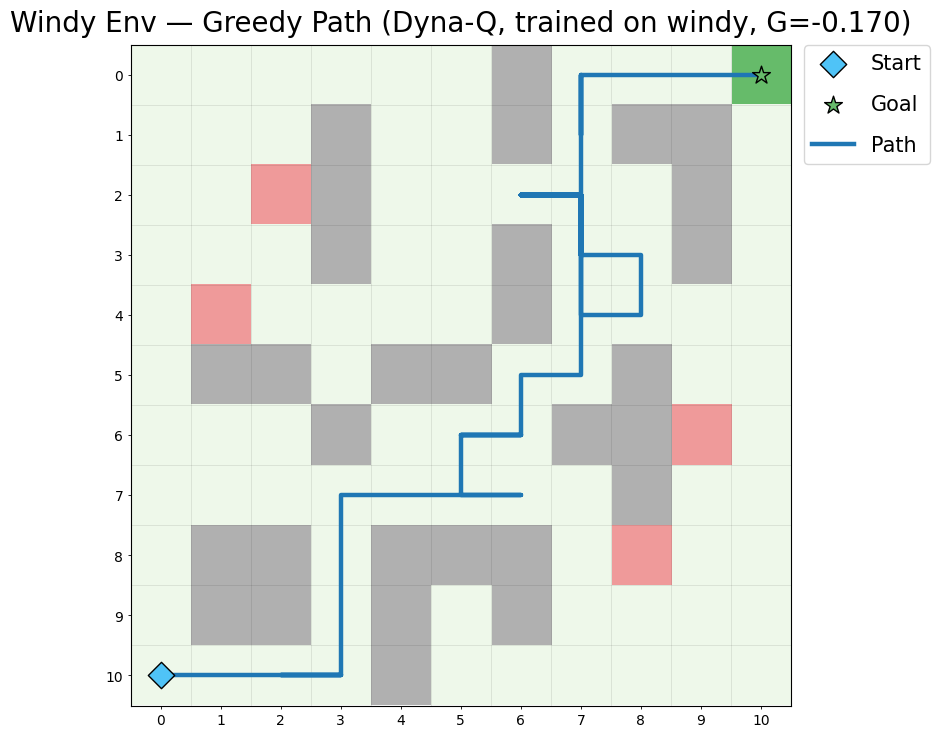

In [13]:
from rl_capstone.utils import run_greedy_episode, idx_traj_to_rc_path

# Paths in windy env – policies trained on baseline env
for name, res in results.items():
    Q = res["Q"]
    G, traj = run_greedy_episode(env_windy, Q, max_steps=cfg.max_steps)
    env_windy.reset()
    env_windy.render(
        path=idx_traj_to_rc_path(env_windy, traj),
        show_agent=False,
        title=f"Windy Env — Greedy Path ({name}, trained on baseline, G={G:.3f})"
    )

# Paths in windy env – policies trained on windy env
for name, res in windy_results.items():
    Q = res["Q"]
    G, traj = run_greedy_episode(env_windy, Q, max_steps=cfg_windy.max_steps)
    env_windy.reset()
    env_windy.render(
        path=idx_traj_to_rc_path(env_windy, traj),
        show_agent=False,
        title=f"Windy Env — Greedy Path ({name}, trained on windy, G={G:.3f})"
    )

## 8) Layout-Shift Robustness
In order to evaluate another aspect of robustness, the user can change the grid world, and see how different the agent behaves while utilizing the different learning model.
The user will be able to visualize the "new" world, train the agent with the learning model as well as the learning curves of the learning process.

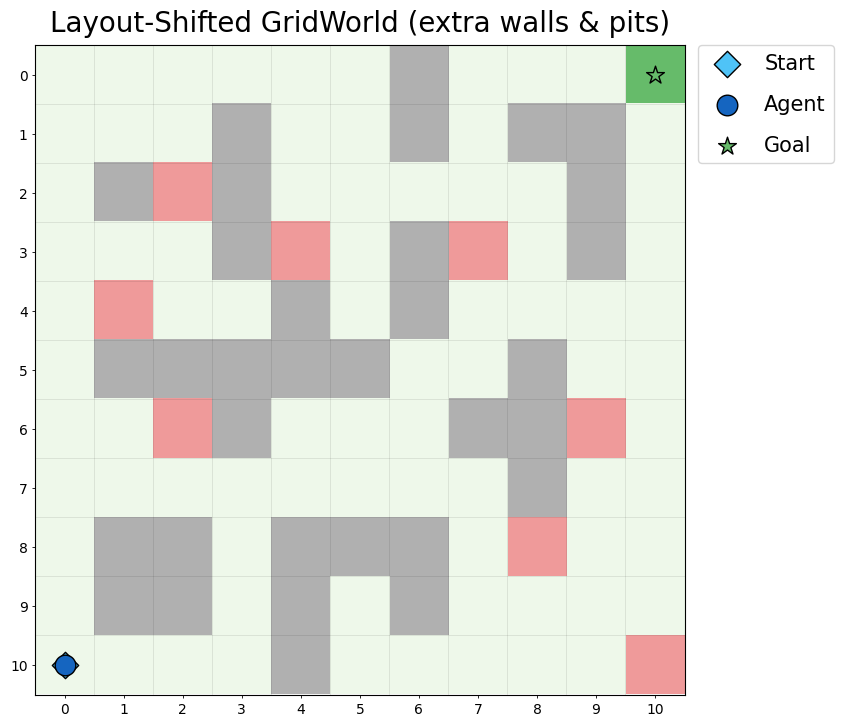


Greedy evaluation on: Layout-shifted env (policies trained on baseline)
------------------------------------------------------------
Q-Learning | Return=-1.092 | Steps=16.8
SARSA      | Return=-1.087 | Steps=16.4
Dyna-Q     | Return=-0.958 | Steps=16.8

Training all algorithms on layout-shifted env...

=== Training Q-Learning ===

=== Training SARSA ===

=== Training Dyna-Q ===
Saved: ../reports/figs/robustness/layout/layout_returns.png


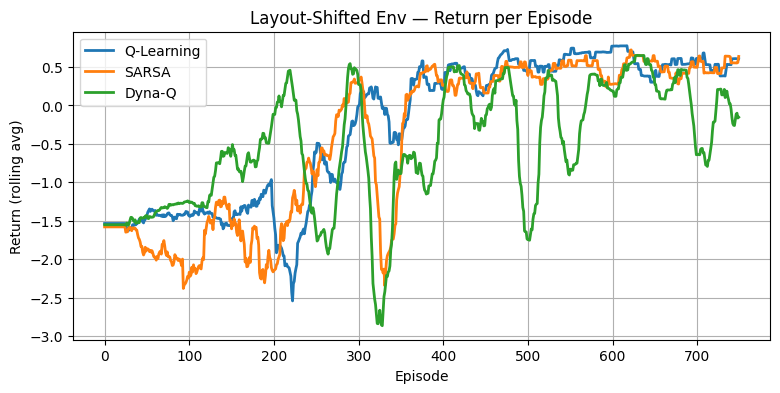

Saved: ../reports/figs/robustness/layout/layout_steps.png


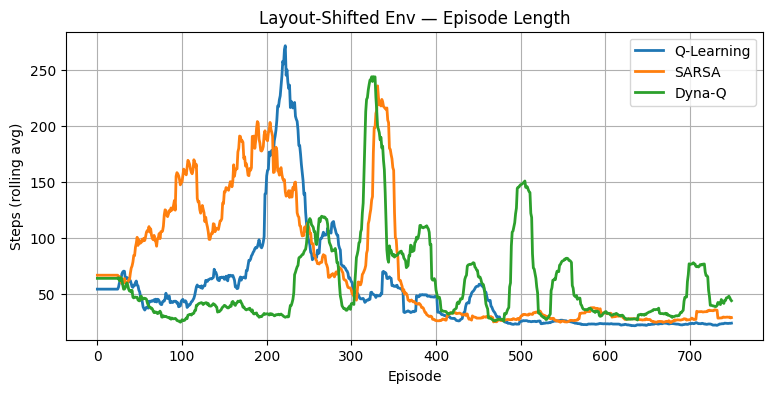


Greedy evaluation on: Layout-shifted env (policies trained on layout-shifted env)
------------------------------------------------------------
Q-Learning | Return=0.652 | Steps=22.4
SARSA      | Return=0.130 | Steps=58.0
Dyna-Q     | Return=0.479 | Steps=53.1


In [19]:
# Extra walls (chosen to tighten corridors but not block all paths, 
# pick cells that don’t block start/goal)
extra_walls = (
    # Near upper-left / mid-left
    (2, 1),
    # Thicken the central vertical spine around col=3
    (5, 3),
    # Add some central clutter
    (4, 4),
)

# Extra pits (bad “tempting” cells along likely routes)
extra_pits = (
    (3, 4),
    (6, 2),
    (10, 10),
    (3, 7),
)

# Combine with original settings
new_walls = settings.walls + extra_walls
new_pits  = settings.pits  + extra_pits

layout_settings = replace(settings, walls=new_walls, pits=new_pits)
env_layout = GridWorld(layout_settings)
env_layout.seed(7)

env_layout.render(title="Layout-Shifted GridWorld (extra walls & pits)")

## 1) Zero-shot: baseline policies in new layout
greedy_eval_on_env(
    env_layout,
    results,
    cfg,
    desc="Layout-shifted env (policies trained on baseline)"
)

# 2) Retrain on new layout
cfg_layout = replace(cfg, seed=42)
print("\nTraining all algorithms on layout-shifted env...")
layout_results = run_all_algorithms(env_layout, cfg_layout, logcfg)

# 3) Save your layout-shift robustness figures here
plot_learning_curves(
    layout_results,
    title_prefix="Layout-Shifted Env",
    save_dir="../reports/figs/robustness/layout",
    prefix="layout"
)

# 4) Greedy evaluation of layout-trained policies on layout env
greedy_eval_on_env(
    env_layout,
    layout_results,
    cfg_layout,
    desc="Layout-shifted env (policies trained on layout-shifted env)"
)


## 9) Seed Stability
Another test that is worth analizing, is randomness of the system. In this case the user can change the random parameters by changing the value of `Seed`.

Some of the parameters that will be affected are 

`Wind randomness`, `Transition noise`, `Length and returns of greedy evaluation episodes`, etc.

(The greater the seed is the more computation will be required, can slow computers down)

### Seed Stability in Baseline & Windy Environment

In [14]:
seed_list = [0, 1, 2, 3, 4]   # more seeds = more compute, smoother stats

# --- Seed stability: layout-shifted environment --- #
print("Running seed-stability experiment on LAYOUT-SHIFTED environment...")
layout_stability = seed_stability_experiment(
    env_layout,
    cfg_layout,
    logcfg,
    seed_list,
    last_n=50
)
print(f"{GREEN}\nTraining in layout-shifted environment completed!{RESET}")

# --- Seed stability: windy environment --- #
print("\nRunning seed-stability experiment on WINDY environment...")
windy_stability = seed_stability_experiment(
    env_windy,
    cfg_windy,
    logcfg,
    seed_list,
    last_n=50
)
print(f"{GREEN}\nTraining in windy environment completed!{RESET}")

# --- Save robustness stats to disk --- #
save_dir = "../data/robustness"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "layout_and_windy_stability.npz")

print(f"\nSaving robustness statistics to {save_path} ...")
try:
    np.savez(
        save_path,
        layout_stability=layout_stability,
        windy_stability=windy_stability,
    )
    print(f"{GREEN}Saved robustness stats successfully!{RESET}")
except Exception as e:
    print(f"{RED}[ERROR] Saving robustness stats failed:{RESET}", e)


Running seed-stability experiment on LAYOUT-SHIFTED environment...

### Seed = 0 ###
  Training Q-Learning...
  Training SARSA...
  Training Dyna-Q...

### Seed = 1 ###
  Training Q-Learning...
  Training SARSA...
  Training Dyna-Q...

### Seed = 2 ###
  Training Q-Learning...
  Training SARSA...
  Training Dyna-Q...

### Seed = 3 ###
  Training Q-Learning...
  Training SARSA...
  Training Dyna-Q...

### Seed = 4 ###
  Training Q-Learning...
  Training SARSA...
  Training Dyna-Q...

Training in layout-shifted environment completed!

Running seed-stability experiment on WINDY environment...

### Seed = 0 ###
  Training Q-Learning...
  Training SARSA...
  Training Dyna-Q...

### Seed = 1 ###
  Training Q-Learning...
  Training SARSA...
  Training Dyna-Q...

### Seed = 2 ###
  Training Q-Learning...
  Training SARSA...
  Training Dyna-Q...

### Seed = 3 ###
  Training Q-Learning...
  Training SARSA...
  Training Dyna-Q...

### Seed = 4 ###
  Training Q-Learning...
  Training SARSA...
  Tr

### Summary + Bar Plot
Finally, the user can visualize how different each algorithm behaved depending on the chosen seed.


Q-Learning
  Returns: mean=0.539, std=0.083
  Steps:   mean=26.3,  std=3.0


SARSA
  Returns: mean=0.624, std=0.103
  Steps:   mean=25.0,  std=1.4


Dyna-Q
  Returns: mean=0.280, std=0.151
  Steps:   mean=41.0,  std=8.2

Saved: ../reports/figs/robustness/layout/layout_seed_stability.png


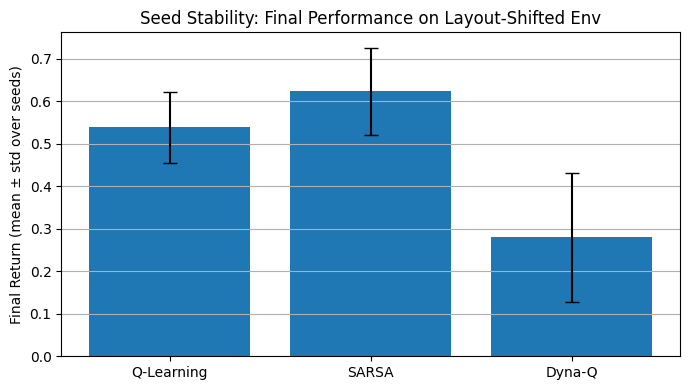

In [15]:
# === Layout-Shift Seed Stability === #

# Print numeric summary
for name, d in layout_stability.items():
    r = np.array(d["final_returns"])
    s = np.array(d["final_steps"])
    print(f"\n{name}")
    print(f"  Returns: mean={r.mean():.3f}, std={r.std():.3f}")
    print(f"  Steps:   mean={s.mean():.1f},  std={s.std():.1f}\n")

# Bar chart of final-return mean ± std
algo_names = list(layout_stability.keys())
means = [np.mean(layout_stability[a]["final_returns"]) for a in algo_names]
stds  = [np.std(layout_stability[a]["final_returns"])  for a in algo_names]

x = np.arange(len(algo_names))
plt.figure(figsize=(7,4))
plt.bar(x, means, yerr=stds, capsize=5)
plt.xticks(x, algo_names)
plt.ylabel("Final Return (mean ± std over seeds)")
plt.title("Seed Stability: Final Performance on Layout-Shifted Env")
plt.grid(axis="y")
plt.tight_layout()

# Save graph
save_plot("../reports/figs/robustness/layout", "layout_seed_stability.png")

plt.show()



Q-Learning
  Returns: mean=0.645, std=0.029
  Steps:   mean=35.7,  std=1.4


SARSA
  Returns: mean=0.661, std=0.021
  Steps:   mean=34.1,  std=0.7


Dyna-Q
  Returns: mean=0.622, std=0.044
  Steps:   mean=37.2,  std=1.9

Saved: ../reports/figs/robustness/windy/windy_seed_stability.png


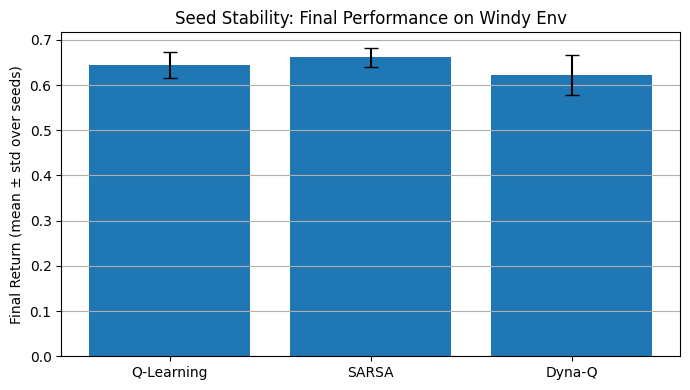

In [18]:
# === Windy-Env Seed Stability === #

# Print numeric summary
for name, d in windy_stability.items():
    r = np.array(d["final_returns"])
    s = np.array(d["final_steps"])
    print(f"\n{name}")
    print(f"  Returns: mean={r.mean():.3f}, std={r.std():.3f}")
    print(f"  Steps:   mean={s.mean():.1f},  std={s.std():.1f}\n")


# Bar chart of final-return mean ± std
algo_names = list(windy_stability.keys())
means = [np.mean(windy_stability[a]["final_returns"]) for a in algo_names]
stds  = [np.std(windy_stability[a]["final_returns"])  for a in algo_names]

x = np.arange(len(algo_names))
plt.figure(figsize=(7,4))
plt.bar(x, means, yerr=stds, capsize=5)
plt.xticks(x, algo_names)
plt.ylabel("Final Return (mean ± std over seeds)")
plt.title("Seed Stability: Final Performance on Windy Env")
plt.grid(axis="y")
plt.tight_layout()

# Save graph
save_plot("../reports/figs/robustness/windy", "windy_seed_stability.png")

plt.show()

In [17]:
layout_stability["Dyna-Q"]["final_returns"]
layout_stability["Dyna-Q"]["final_steps"]

[40.32, 57.04, 34.16, 37.5, 36.18]

---

## Conclusion

The different experiments probed two axes of "real-world-messiness":

1. **Dynamics shift:** adding extra wind to the transition dynamics.
2. **Layout shift:** changing the walls/pits while keeping start/goal the same.

We compared **Q-Learning, SARSA,** and **Dyna-Q** under both types of shift and also looked at **seed stability** (mean += std over multiple random seeds).

---

### Robustness to stochastic dynamics (windy environment)
When we retrain all three algorithms directly in the windy GridWolrd:

* All methods eventually reach **similar final performance**.

  * Greedy eval after training:

    * Q-Learning: return ≈ **0.64, ~36.7** steps

    * SARSA: return ≈ **0.70, ~31.3** steps.

    * Dyna-Q: return ≈ **0.58, ~42.8** steps.

  * The learning curves show that **Dyna-Q learns fastest early on** (its green curve climbs first), but its final policy in this particular windy setting is slightly worse (lower return, longer paths) than the purely model-free methods.

  * Seed-stability on the windy environment is **very high for all three**.
    
     * Q-learning: mean return ≈ **0.66**, std = **0.02**.
     
     * SARSA: mean return ≈ **0.66**, std ≈ **0.02**
     
     * Dyna-Q: mean return ≈ **0.63**, std ≈ **0.03**

So under **moderate stochasticity**, all methods converge reliably and Dyna-Q does not collapse, but its model-based updates don’t give a big robustness advantage either. The model appears accurate enough to accelerate early learning but not so accurate that heavy planning gives a clearly better final policy.

---

### Robustness to layout shift

Layout shift is much harsher: we first take policies **trained on the baseline map** and evaluate them **without further learning** on the new layout.

* Cross-evaluation on the shifted layout (no retraining):

  * Q-Learning: return ≈ **–1.02** (often falls into pits), ~**16.6** steps
  
  * SARSA: return ≈ **0.52**, ~**22.4** steps
 
  * Dyna-Q: return ≈ –**0.96**, ~**16.9** steps

Here, **SARSA** is clearly **more robust**: it remains positive and takes reasonably long paths, while Q-Learning and Dyna-Q do very poorly (strongly negative returns, short trajectories that often end in pits). Intuitively:

* Q-Learning and Dyna-Q are **more off-policy**: they aggressively propagate value along whatever greedy path was optimal in the original layout. When the map changes (new walls/pits), that path can become catastrophic.

* SARSA learns values **on the actual behavior policy**; its paths tend to be more conservative and less “knife-edge optimal,” so they degrade more gracefully under a layout change.

When we **retrain from scratch** on the layout-shifted environment, all three algorithms eventually reach almost identical final performance:

* Greedy eval after retraining:

    * Q-Learning: return ≈ **0.72**, ~**22.8** steps
    
    * SARSA: return ≈ **0.72**, ~**22.7** steps
 
    * Dyna-Q: return ≈ **0.71**, ~**23.0** steps

So **given enough experience in the new layout**, every method can re-adapt and recover an optimal policy.

However, seed stability on the layout-shifted env reveals an important difference:

Q-Learning: mean return ≈ **0.60**, std ≈ **0.10**

SARSA: mean return ≈ **0.59**, std ≈ **0.05**

Dyna-Q: mean return ≈ **0.10**, std ≈ **0.33**

The **mean performance of Dyna-Q is much lower and its variance much higher** across seeds. Some seeds discover good models and policies, but others get “stuck” in poor value basins and never fully recover. The extra planning amplifies whatever experience the agent happens to see early on; when the layout is tricky, that early experience can be misleading, and planning makes the mis-generalization worse.

---

### Overall robustness picture

Putting everything together:

* Under mild stochasticity (wind), all three methods are quite robust. Dyna-Q learns quickly and ends up only slightly behind Q-Learning/SARSA in final performance, with comparable seed stability.

* Under hard layout shift, the picture changes:

    * Policies trained on the old layout do not transfer well for Q-Learning and Dyna-Q; SARSA degrades more gracefully.
    
    * After retraining, all methods can adapt, but Dyna-Q is far more seed-sensitive: some runs do great, others fail badly.

* This highlights a trade-off:

    * Model-based planning (Dyna-Q) → faster learning, but more fragile when the environment changes or when early experience is misleading.
    
    * Model-free methods (Q-Learning, SARSA) → slower, but more stable and predictable across seeds and environment variants.

---

<style>
    .button {
        background-color: #3b3b3b;
        color: white;
        padding: 25px 60px;
        border: none;
        border-radius: 12px;
        cursor: pointer;
        font-size: 30px;
        transition: background-color 0.3s ease;
    }

    .button:hover {
        background-color: #45a049;
        transform: scale(1.05);
    }
    
</style>

<div style=" text-align: center; margin-top:20px;">
    
  <a href="05_k_sweep.ipynb">
    <button class="button">
      ⬅️ Prev: K Sweeping Dyna-Q
    </button>
  </a>
  <span style="display:inline-block; width:200px;"></span>
  <a href="07_results.ipynb">
    <button class="button">
      Next: Results ➡️
    </button>
  </a>
  
</div>
